# Profile-based information retrieval

The main goal of this study is to implement an information retrieval engine targeted at delivering small text snippets to different users depending on their profile. The approached method to build the User Based Information Retrieval algorithm is based on computing the cosine similarity between an input document and each possible user profile. A public dataset from the BBC comprised of 1490 articles, each labeled under one of 5 categories will be used: business, entertainment, politics, sport or tech. 


### 0. Libraries and data loading

In [1]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]    | 

True

In [2]:
!pip install evaltools

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for evaltools: filename=evaltools-0.0-py3-none-any.whl size=2742 sha256=b13fb93100e4290f6efd1b4dec85f7f3f6c28e211154698408a55e695a531791
  Stored in directory: c:\users\ander\appdata\local\pip\cache\wheels\f0\87\f0\c86abc8999ec03e3a5d565ef26adb7f429d2fa149bbac3f495
Successfully built evaltools


In [10]:
#!pip install nltk
import pandas as pd
# import os
import matplotlib
# import seaborn as sns
import string
# import os
import numpy as np
# import string as st
import re
# import math
import nltk
from nltk import PorterStemmer, WordNetLemmatizer
# from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.feature_extraction.text import CountVectorizer
import random
from evaltools import *
# %matplotlib inline

In [13]:
train = pd.read_csv('data/BBC News Train.csv')

# Remove duplicated data
train = train.drop_duplicates(subset=['Text','Category'])
train.head()

ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

In [14]:
train.shape

(1440, 3)

In [15]:
train.groupby(['Category']).size().sort_values(ascending=True)

Category
tech             234
entertainment    263
politics         266
business         335
sport            342
dtype: int64

<Axes: ylabel='Category'>

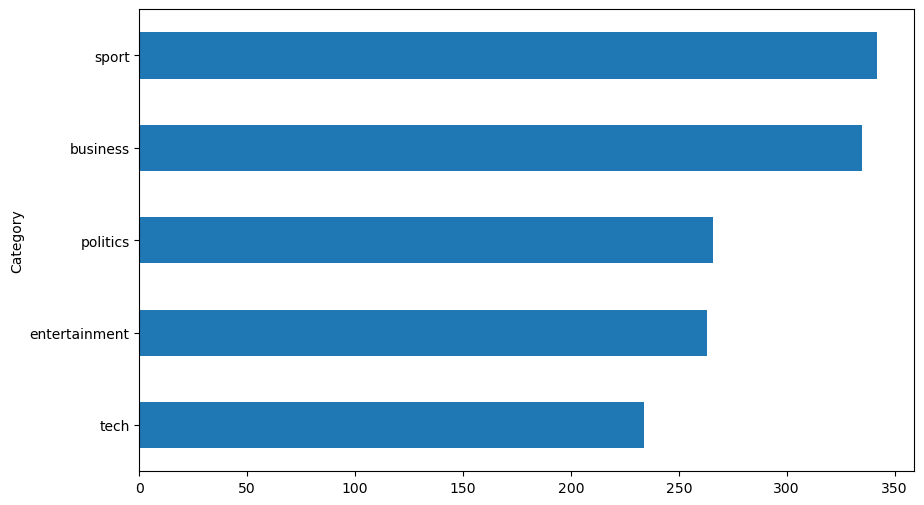

In [16]:
train.groupby(['Category']).size().sort_values(ascending=True).plot(kind='barh', figsize=(10, 6))

## 1. Data preprocessing
Several preprocessing functions will be applied to the documents in order to encode them

In [17]:
#1. Remove all punctuations from the text
def remove_punct(text):
    return "".join([ch for ch in text if ch not in string.punctuation])

#2. Convert text to lower case tokens. 
def tokenize(text):
    text = re.split('\s+' ,text)
    return [x.lower() for x in text]

#3. Remove tokens of length less than 3
def remove_small_words(text):
    return [x for x in text if len(x) > 3 ]

#4. Remove stop words by using NLTK corpus list
def remove_stopwords(text):
    return [word for word in text if word not in nltk.corpus.stopwords.words('english')]

#5. Apply stemming to get root words. This step is optional and it depends on problem type
def stemming(text):
    ps = PorterStemmer()
    return [ps.stem(word) for word in text]

#6. Apply lemmatization on tokens to get the diccionary-based form
def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

#7. Annotate each word with its part-of-speech tag
def get_pos_tag(tokenized_sentence):
    return nltk.pos_tag(tokenized_sentence)

#8. Create sentences to get clean text as input for vectors
def return_sentences(tokens):
    return " ".join([word for word in tokens])

def preprocessing_nlp (df):
    df['removed_punc'] = df['Text'].apply(lambda x: remove_punct(x))
    df['tokens'] = df['removed_punc'].apply(lambda msg : tokenize(msg))
    df['larger_tokens'] = df['tokens'].apply(lambda x : remove_small_words(x))
    df['clean_tokens'] = df['larger_tokens'].apply(lambda x : remove_stopwords(x))
    #df['stem_words'] = df['clean_tokens'].apply(lambda wrd: stemming(wrd))
    df['lemma_words'] = df['clean_tokens'].apply(lambda x : lemmatize(x))
    #df['pos_tag'] = df['tokens'].apply(lambda x : get_pos_tag(x))
    df['clean_text'] = df['lemma_words'].apply(lambda x : return_sentences(x))
    return(df)


In [18]:
train = preprocessing_nlp(train)
train.head()

ArticleId                                               Text  Category  \
0       1833  worldcom ex-boss launches defence lawyers defe...  business   
1        154  german business confidence slides german busin...  business   
2       1101  bbc poll indicates economic gloom citizens in ...  business   
3       1976  lifestyle  governs mobile choice  faster  bett...      tech   
4        917  enron bosses in $168m payout eighteen former e...  business   

                                        removed_punc  \
0  worldcom exboss launches defence lawyers defen...   
1  german business confidence slides german busin...   
2  bbc poll indicates economic gloom citizens in ...   
3  lifestyle  governs mobile choice  faster  bett...   
4  enron bosses in 168m payout eighteen former en...   

                                              tokens  \
0  [worldcom, exboss, launches, defence, lawyers,...   
1  [german, business, confidence, slides, german,...   
2  [bbc, poll, indicates, economic, gloom, citize...   
3  [lifestyle, governs, mobile, choice, faster, b...   
4  [enron, bosses, in, 168m, payout, eighteen, fo...   

                                       larger_tokens  \
0  [worldcom, exboss, launches, defence, lawyers,...   
1  [german, business, confidence, slides, german,...   
2  [poll, indicates, economic, gloom, citizens, m...   
3  [lifestyle, governs, mobile, choice, faster, b...   
4  [enron, bosses, 168m, payout, eighteen, former...   

                                        clean_tokens  \
0  [worldcom, exboss, launches, defence, lawyers,...   
1  [german, business, confidence, slides, german,...   
2  [poll, indicates, economic, gloom, citizens, m...   
3  [lifestyle, governs, mobile, choice, faster, b...   
4  [enron, bosses, 168m, payout, eighteen, former...   

                                         lemma_words  \
0  [worldcom, exboss, launch, defence, lawyer, de...   
1  [german, business, confidence, slide, german, ...   
2  [poll, indicates, economic, gloom, citizen, ma...   
3  [lifestyle, governs, mobile, choice, faster, b...   
4  [enron, boss, 168m, payout, eighteen, former, ...   

                                          clean_text  
0  worldcom exboss launch defence lawyer defendin...  
1  german business confidence slide german busine...  
2  poll indicates economic gloom citizen majority...  
3  lifestyle governs mobile choice faster better ...  
4  enron boss 168m payout eighteen former enron d...

In [26]:
train = train[['Category','clean_text']]
train.head()

Category                                         clean_text
0  business  worldcom exboss launch defence lawyer defendin...
1  business  german business confidence slide german busine...
2  business  poll indicates economic gloom citizen majority...
3      tech  lifestyle governs mobile choice faster better ...
4  business  enron boss 168m payout eighteen former enron d...

## 2. Algorithm used to process the queries

### 2.1. Cosine Similarity TF-IDF Vectors
The approached method to build the User Based Information Retrieval algorithm is based on computing the cosine similarity between an input document and each possible type of user.

##### Representing each document as a TF-IDF vector
First, documents are going to be defined as a vectors depending on the importance of their word in each document. The TF-IDF matrix, which represents the importance of each term in each document within a corpus, is also calculated based on term frequency and inverse document frequency.

In [27]:
tfidf = TfidfVectorizer(norm='l2', use_idf=False)
tfidf_matrix = tfidf.fit_transform(train['clean_text']).toarray()

In [28]:
# TF-IDF matrix
tokens = []
for i, feature in enumerate(tfidf.get_feature_names_out()):
    tokens.append(feature)
m = pd.DataFrame(tfidf_matrix, columns = tokens)
m.iloc[:,9000:]


fourtime  fourtimes  fourtou  fourwheeldrive  fouryear  fouryearolds  \
0          0.0        0.0      0.0             0.0       0.0           0.0   
1          0.0        0.0      0.0             0.0       0.0           0.0   
2          0.0        0.0      0.0             0.0       0.0           0.0   
3          0.0        0.0      0.0             0.0       0.0           0.0   
4          0.0        0.0      0.0             0.0       0.0           0.0   
...        ...        ...      ...             ...       ...           ...   
1435       0.0        0.0      0.0             0.0       0.0           0.0   
1436       0.0        0.0      0.0             0.0       0.0           0.0   
1437       0.0        0.0      0.0             0.0       0.0           0.0   
1438       0.0        0.0      0.0             0.0       0.0           0.0   
1439       0.0        0.0      0.0             0.0       0.0           0.0   

      fowler  fox  foxed  foxx  ...  zombie  zone  zonealarm  zoom  zooropa  \
0        0.0  0.0    0.0   0.0  ...     0.0   0.0        0.0   0.0      0.0   
1        0.0  0.0    0.0   0.0  ...     0.0   0.0        0.0   0.0      0.0   
2        0.0  0.0    0.0   0.0  ...     0.0   0.0        0.0   0.0      0.0   
3        0.0  0.0    0.0   0.0  ...     0.0   0.0        0.0   0.0      0.0   
4        0.0  0.0    0.0   0.0  ...     0.0   0.0        0.0   0.0      0.0   
...      ...  ...    ...   ...  ...     ...   ...        ...   ...      ...   
1435     0.0  0.0    0.0   0.0  ...     0.0   0.0        0.0   0.0      0.0   
1436     0.0  0.0    0.0   0.0  ...     0.0   0.0        0.0   0.0      0.0   
1437     0.0  0.0    0.0   0.0  ...     0.0   0.0        0.0   0.0      0.0   
1438     0.0  0.0    0.0   0.0  ...     0.0   0.0        0.0   0.0      0.0   
1439     0.0  0.0    0.0   0.0  ...     0.0   0.0        0.0   0.0      0.0   

      zorro  zuluaga  zurich  zutons  zvonareva  
0       0.0      0.0     0.0     0.0        0.0  
1       0.0      0.0     0.0     0.0        0.0  
2       0.0      0.0     0.0     0.0        0.0  
3       0.0      0.0     0.0     0.0        0.0  
4       0.0      0.0     0.0     0.0        0.0  
...     ...      ...     ...     ...        ...  
1435    0.0      0.0     0.0     0.0        0.0  
1436    0.0      0.0     0.0     0.0        0.0  
1437    0.0      0.0     0.0     0.0        0.0  
1438    0.0      0.0     0.0     0.0        0.0  
1439    0.0      0.0     0.0     0.0        0.0  

[1440 rows x 14294 columns]

In [29]:
document_vectors = tfidf.fit_transform(train["clean_text"])

###### 2.1.1. Ad-hoc aproach
An ad-hoc model allow us a great performance, performing a great retrieval task but it won't work in other datasets.

##### Defining unique interests vectors as a weighted TF-IDF vector
For the information retrieval, the interests of each users need to be vectorized. First, before vectrorizing, the interests were defined taking into account the most common words in every document category in our dataset. These categories are: business, tech, politics, sport and entertainment. First, the N most frequent words for each theme were obtained. Then, the  unique most common words were obtained. By unique words, it is meant to select the words are only present for one specific theme and not in the others.

In [30]:
users= {
    'user1': 'business',
    'user2': 'tech',
    'user3': 'politics',
    'user4': 'sports',
    'user5': 'entertainment'
}


In [31]:
sports = train[train['Category'] == 'sport']
business = train[train['Category'] == 'business']
tech =  train[train['Category'] == 'tech']
entertainment = train[train['Category'] == 'entertainment']
politics = train[train['Category'] == 'politics']

politics.head()

Category                                         clean_text
5   politics  howard truanted play snooker conservative lead...
10  politics  blair reject iraq advice call tony blair rejec...
28  politics  stand firm rebate britain £3bn rebate renegoti...
33  politics  security paper found street inquiry file conta...
52  politics  quiz aide royal income senior official body ge...

In [32]:
def get_vector_theme(df, n=50):
    #tfidf = CountVectorizer()
    tfidf = TfidfVectorizer()
    theme_tfidf = tfidf.fit_transform(df['clean_text'])

    theme_tf_matrix = theme_tfidf.toarray()
    theme_tf_sum = np.sum(theme_tf_matrix, axis=0)
    sorted_indices = np.argsort(theme_tf_sum)[::-1]

    feature_names = np.array(list(tfidf.vocabulary_.keys())) 
    feature_counts = np.array(list(tfidf.vocabulary_.values())) 
    sorted_features = feature_names[np.argsort(feature_counts)]

    # Extract the N most frequent terms
    top_terms = sorted_features[sorted_indices[:n]]

    return top_terms[:n]

# Unique words all categories
all_keywords = set()

def get_vector_theme_unique(df, all_keywords, n=50):
    # tfidf = CountVectorizer()
    tfidf = TfidfVectorizer()
    theme_tfidf = tfidf.fit_transform(df['clean_text'])

    theme_tf_matrix = theme_tfidf.toarray()
    theme_tf_sum = np.sum(theme_tf_matrix, axis=0)
    sorted_indices = np.argsort(theme_tf_sum)[::-1]

    feature_names = np.array(list(tfidf.vocabulary_.keys())) 
    feature_counts = np.array(list(tfidf.vocabulary_.values())) 
    sorted_features = feature_names[np.argsort(feature_counts)]

    # Extract the n most frequent terms
    top_terms = sorted_features[sorted_indices[:n]]
    
    all_keywords.update(top_terms[:n])
    return top_terms[:n]

# Unique words for each category
business_keywords = set(get_vector_theme_unique(business, all_keywords))
tech_keywords = set(get_vector_theme_unique(tech, all_keywords))
politics_keywords = set(get_vector_theme_unique(politics, all_keywords))
sports_keywords = set(get_vector_theme_unique(sports, all_keywords))
entertainment_keywords = set(get_vector_theme_unique(entertainment, all_keywords))

# Final unique words for each category
final_business_keywords = business_keywords - (all_keywords - business_keywords)
final_tech_keywords = tech_keywords - (all_keywords - tech_keywords)
final_politics_keywords = politics_keywords - (all_keywords - politics_keywords)
final_sports_keywords = sports_keywords - (all_keywords - sports_keywords)
final_entertainment_keywords = entertainment_keywords - (all_keywords - entertainment_keywords)

print("Most common words in 'business' documents:", final_business_keywords)
print("Most common words in 'tech' documents:", final_tech_keywords)
print("Most common words in 'politics' documents:", final_politics_keywords)
print("Most common words in 'sports' documents:", final_sports_keywords)
print("Most common words in 'entertainment' documents:", final_entertainment_keywords)


Most common words in 'business' documents: {'time', 'economic', 'company', 'quarter', 'would', 'euro', 'analyst', 'interest', 'world', 'market', 'spending', 'group', 'however', 'price', 'month', 'china', 'trade', 'country', 'sale', '2004', 'could', 'profit', 'chief', 'year', 'said', 'rise', 'deal', 'business', '2005', 'figure', 'financial', 'firm', 'demand', 'people', 'yukos', 'last', 'india', 'also', 'government', 'share', 'expected', 'growth', 'cost', 'bank', 'rate', 'airline', 'investment', 'economy', 'dollar', 'deficit'}
Most common words in 'tech' documents: {'game', 'search', 'mobile', 'music', 'time', 'company', 'would', 'virus', 'technology', 'consumer', 'data', 'machine', 'market', 'network', 'microsoft', 'million', 'online', 'service', 'phone', 'site', 'could', 'software', 'information', 'broadband', 'used', 'year', 'system', 'first', 'said', 'sony', 'digital', 'firm', 'internet', 'people', 'user', 'also', 'email', 'number', 'video', 'many', 'make', 'medium', 'gadget', 'like'

> Hay palabras que no son muy relevantes por cada topic. No se si estoy haciendo algo mal o no tengo ni idea de como lo mejoraria. Supongo que esta bien pero comentadlo en el report :) Creo que lo de unique no lo pilla bien

##### Defining users
Once we have every interest as a vector with the the most common words for every category in the initial dataset, we are going to define 7 different users with different interests. The users and their interests are the following:
- User 1: sport
- User 2: tech
- User 3: tech and business
- User 4: entertainment and business
- User 5: sport and politics
- User 6: politics and entertainment
- User 7: sport and tech

Then, the words of interest for each user will be obtained and then users will be vectorized.

In [33]:
user_interests = {
    "user1": ["sport"],
    "user2": ["tech"],
    "user3": ["tech", "business"],
    "user4": ["entertainment", "business"],
    "user5": ["sport", "politics"],
    "user6": ["politics", "entertainment"],
    "user7": ["sport", "tech"]
}

# Definir una lista de todos los posibles temas de interés
all_interests = list(set([interest for interests in user_interests.values() for interest in interests]))

#users_keywords = [final_business_keywords, final_tech_keywords, final_politics_keywords, final_sports_keywords, final_entertainment_keywords]

# Obtener los vectores de palabras clave finales para cada interés
users_keywords = {}
for user, interests in user_interests.items():
    final_keywords = []
    for interest in interests:
        if interest == 'business':
            final_keywords.extend(final_business_keywords)
        elif interest == 'tech':
            final_keywords.extend(final_tech_keywords)
        elif interest == 'politics':
            final_keywords.extend(final_politics_keywords)
        elif interest == 'sport':
            final_keywords.extend(final_sports_keywords)
        elif interest == 'entertainment':
            final_keywords.extend(final_entertainment_keywords)
    users_keywords[user] = final_keywords

users_vectors = []

# User vectors for each user
for keywords in users_keywords.values():
    users_vectors.append(tfidf.transform([" ".join(keywords)]))

# Adding additional vectors for users with multiple interests
for user, interests in user_interests.items():
    if len(interests) > 1:
        combined_vector = sum(users_vectors[all_interests.index(interest)] for interest in interests) / len(interests)
        users_vectors.append(combined_vector)

print(users_vectors)


[<1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 50 stored elements in Compressed Sparse Row format>, <1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 50 stored elements in Compressed Sparse Row format>, <1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 90 stored elements in Compressed Sparse Row format>, <1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 90 stored elements in Compressed Sparse Row format>, <1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 93 stored elements in Compressed Sparse Row format>, <1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 93 stored elements in Compressed Sparse Row format>, <1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 90 stored elements in Compressed Sparse Row format>, <1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 90 stored elements in Compressed Sparse Row format>, <1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 128 stor

In [34]:
users_keywords

{'user1': ['title',
  'game',
  'time',
  'would',
  'england',
  'france',
  'take',
  'next',
  'world',
  'club',
  'match',
  'arsenal',
  'wale',
  'final',
  'three',
  'team',
  'want',
  'nation',
  'season',
  'williams',
  'think',
  'chelsea',
  'second',
  'could',
  'goal',
  'well',
  'year',
  'first',
  'said',
  'coach',
  'play',
  'side',
  'united',
  'league',
  'champion',
  'robinson',
  'last',
  'rugby',
  'also',
  'open',
  'ireland',
  'good',
  'player',
  'like',
  'back',
  'great',
  'international',
  'week',
  'injury',
  'minute'],
 'user2': ['game',
  'search',
  'mobile',
  'music',
  'time',
  'company',
  'would',
  'virus',
  'technology',
  'consumer',
  'data',
  'machine',
  'market',
  'network',
  'microsoft',
  'million',
  'online',
  'service',
  'phone',
  'site',
  'could',
  'software',
  'information',
  'broadband',
  'used',
  'year',
  'system',
  'first',
  'said',
  'sony',
  'digital',
  'firm',
  'internet',
  'people',
  'user

### Solution 1. Information retrieval system given a vector of user interests
Given the vector of a user define by its interests, the cosine similarity has been calculated with every document. Therefore, the most relevant documents for every user are displaied, taking into account the user's interest. The more similarity, the more relevant the document is to the user's interest.

In [35]:
# Creating a Dataframe
sim_df = pd.DataFrame(columns=['Text', 'Category'] + list(user_interests.keys()))

sim_df['Text'] = train['clean_text']
sim_df['Category'] = train['Category']

# Calculating similarities
for user, user_vector in zip(user_interests.keys(), users_vectors):
    similarities_list = []
    for document_vector in document_vectors:
        similarity = cosine_similarity(user_vector, document_vector)
        similarities_list.append(similarity[0][0])
    sim_df[user] = similarities_list

sim_df.head()


Text  Category     user1  \
0  worldcom exboss launch defence lawyer defendin...  business  0.077396   
1  german business confidence slide german busine...  business  0.102138   
2  poll indicates economic gloom citizen majority...  business  0.122474   
3  lifestyle governs mobile choice faster better ...      tech  0.081350   
4  enron boss 168m payout eighteen former enron d...  business  0.052103   

      user2     user3     user4     user5     user6     user7  
0  0.098504  0.158960  0.163501  0.093194  0.111833  0.113543  
1  0.086424  0.289076  0.319505  0.114472  0.135285  0.121716  
2  0.112268  0.283287  0.319522  0.202777  0.233193  0.151526  
3  0.312554  0.298484  0.174116  0.141777  0.167297  0.254264  
4  0.081876  0.158551  0.172965  0.059153  0.093659  0.086483

In [39]:
document_vector

<1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 101 stored elements in Compressed Sparse Row format>

In [83]:
sort_1 = sim_df.sort_values('user1', ascending=False)
sort_1[:10]['Text']

293     celt savour grand slam prospect nation heralde...
621     robinson answer critic england captain jason r...
778     november remember last saturday newspaper proc...
1239    year remember irish used subliminal moment yea...
599     paris promise raise welsh hope better nation m...
172     gara revel ireland victory ireland flyhalf ron...
785     robinson want dual code success england rugby ...
1468    preview ireland england lansdowne road dublin ...
694     time tough friendly international manager frie...
724     veteran martinez win thai title conchita marti...
Name: Text, dtype: object

In [ ]:
!pip install pandas nltk scikit-learn

In [ ]:
import pandas as pd
import nltk

In [ ]:
dtypes = {
    'ArticleId': 'int32',
    'Text': 'str',
    'Category': 'category'
}
data_train = pd.read_csv('data/BBC News Train.csv', dtype=dtypes, encoding='utf-8', index_col='ArticleId')
data_test = pd.read_csv('data/BBC News Test.csv', dtype={'ArticleId': 'int32', 'Text': 'str'}, encoding='utf-8', index_col='ArticleId')
data_test_solution = pd.read_csv('data/BBC News Sample Solution.csv', dtype={'ArticleId': 'int32', 'Category': 'category'}, encoding='utf-8', index_col='ArticleId')
data_test['Category'] = data_test_solution['Category']
data = pd.concat([data_train, data_test])
data.head(10)

Text       Category
ArticleId                                                                  
1833       worldcom ex-boss launches defence lawyers defe...       business
154        german business confidence slides german busin...       business
1101       bbc poll indicates economic gloom citizens in ...       business
1976       lifestyle  governs mobile choice  faster  bett...           tech
917        enron bosses in $168m payout eighteen former e...       business
1582       howard  truanted to play snooker  conservative...       politics
651        wales silent on grand slam talk rhys williams ...          sport
1797       french honour for director parker british film...  entertainment
2034       car giant hit by mercedes slump a slump in pro...       business
1866       fockers fuel festive film chart comedy meet th...  entertainment

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2225 entries, 1833 to 471
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Text      2225 non-null   object  
 1   Category  2225 non-null   category
dtypes: category(1), object(1)
memory usage: 28.5+ KB


In [ ]:
data.Category.value_counts()

Category
sport            493
business         483
politics         421
entertainment    420
tech             408
Name: count, dtype: int64

## Preprocessing

### Lowercasing

In [ ]:
def lowercase_data(data: pd.DataFrame) -> pd.DataFrame:
    new_data = data.copy()
    new_data['Text'] = new_data['Text'].str.lower()
    return new_data

### Punctuation Removal

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-z]+')

def remove_punctuation(data: pd.DataFrame) -> pd.DataFrame:
    new_data = data.copy()
    new_data['Text'] = new_data['Text'].apply(tokenizer.tokenize)
    return new_data

### Stopwords Removal

In [ ]:
from nltk.corpus import stopwords

nltk.download('stopwords')

def remove_stopwords(data: pd.DataFrame) -> pd.DataFrame:
    stop_words = set(stopwords.words('english'))
    new_data = data.copy()
    new_data['Text'] = new_data['Text'].apply(lambda x: [word for word in tuple(x) if word not in stop_words and len(word) > 3])
    return new_data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Lemmatization

In [ ]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
def lemmatize_data(data: pd.DataFrame) -> pd.DataFrame:
    lemmatizer = WordNetLemmatizer()
    new_data = data.copy()
    new_data['Text'] = new_data['Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))
    return new_data

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Stemming

In [ ]:
from nltk.stem import PorterStemmer

nltk.download('punkt')
def stem_data(data: pd.DataFrame) -> pd.DataFrame:
    stemmer = PorterStemmer()
    new_data = data.copy()
    new_data['Text'] = new_data['Text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x]))
    return new_data

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Compute tf-idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(data: pd.DataFrame) -> (TfidfVectorizer, pd.DataFrame):
    # Drop rows with NaN values in the 'Text' column
    data = data.dropna(subset=['Text'])
    vectorizer = TfidfVectorizer()
    
    X = vectorizer.fit_transform(data['Text'])
    return vectorizer, X

In [ ]:
data = lowercase_data(data)
data = remove_punctuation(data)
data = remove_stopwords(data)

data = lemmatize_data(data)
# data_stemmed = stem_data(data)

# Using tf-idf

In [ ]:

# Apply TF-IDF separately for each category DataFrame
vectorizer_category_sport, tf_idf_category_sport = get_tfidf(categorySport_df)
vectorizer_category_tech, tf_idf_category_tech = get_tfidf(categoryTech_df)
vectorizer_category_business, tf_idf_category_business = get_tfidf(categoryBusiness_df)
vectorizer_category_entertainment, tf_idf_category_entertainment = get_tfidf(categoryEntertainment_df)
vectorizer_category_politics, tf_idf_category_politics = get_tfidf(categoryPolitics_df)


# Using word embeddings

In [ ]:
from gensim.models import Word2Vec
import numpy as np

def get_word_embeddings(data: pd.DataFrame) -> Word2Vec:
    sentences = data['Text'].apply(lambda x: x.split())
    vector_size = len(data)
    model = Word2Vec(sentences, vector_size=vector_size, window=6, min_count=5, workers=4)
    return model

In [ ]:
word_embeddings_lemmatized = get_word_embeddings(data_lemmatized)
word_embeddings_stemmed = get_word_embeddings(data_stemmed)

In [ ]:
data_lemmatized['WordEmbeddings'] = data_lemmatized['Text'].apply(lambda x: Word2Vec(x, vector_size=np.min(data_lemmatized['Text'].apply(len)), window=6, min_count=5, workers=4).wv.vectors)

In [ ]:
data_stemmed['WordEmbeddings'] = data_stemmed['Text'].apply(lambda x: Word2Vec(x, vector_size=np.min(data_stemmed['Text'].apply(len)), window=6, min_count=5, workers=4).wv.vectors)

In [ ]:
# Average word embeddings for each document by average each column
data_lemmatized['WordEmbeddings'] = [np.mean(data_lemmatized['WordEmbeddings'][index], axis=0) for index in data_lemmatized.index]

In [ ]:
# Find word using tf-idf
def find_word_tfidf(word: str, vectorizer: TfidfVectorizer, X: np.ndarray) -> np.ndarray:
    word_index = vectorizer.vocabulary_.get(word)
    if word_index is None:
        return None
    return X[:, word_index]

In [ ]:
# Find word using word embeddings
def find_word_embeddings(word: str, model: Word2Vec) -> np.ndarray:
    return model.wv[word]

In [ ]:
def get_ranked_documents_lemmatized(query: str) -> np.array:
    indices = find_word_tfidf(query, vectorizer_lemmatizer, tf_idf_lemmatized).toarray()
    sorted_indices = [(index, value[0]) for index, value in sorted(enumerate(indices), key=lambda x: x[1], reverse=False)]
    return np.array([data.index[index] for index, _ in sorted_indices])

In [ ]:
def get_ranked_documents_stemmed(query: str) -> np.array:
    indices = find_word_tfidf(query, vectorizer_stemmer, tf_idf_stemmed).toarray()
    sorted_indices = [(index, value[0]) for index, value in sorted(enumerate(indices), key=lambda x: x[1], reverse=False)]
    return np.array([data.index[index] for index, _ in sorted_indices])

In [ ]:
def get_ranked_documents_word_embeddings_lemmatized(query: str) -> np.array:
    indices = find_word_embeddings(query, word_embeddings_lemmatized)
    sorted_indices = [(index, value) for index, value in sorted(enumerate(indices), key=lambda x: x[1], reverse=False)]
    return np.array([index for index, _ in sorted_indices])

In [ ]:
def get_ranked_documents_word_embeddings_stemmed(query: str) -> np.array:
    indices = find_word_embeddings(query, word_embeddings_stemmed)
    sorted_indices = [(index, value) for index, value in sorted(enumerate(indices), key=lambda x: x[1], reverse=False)]
    return np.array([index for index, _ in sorted_indices])

In [ ]:
def get_document_relevance(query: str) -> np.array:
    return np.array(data['Category'].apply(lambda x: 1 if (x == query) else -1))

In [ ]:
Q = []
R = []
for query in data['Category'].unique():
    Q.append(get_ranked_documents_word_embeddings_lemmatized(query))
    R.append(get_document_relevance(query))

To select a evaluation method set the variable 'method' of the cell below to any of the following values:

* 'prec_rec': draw the Precision-Recall curve for each query;
* 'r-prec': Determine the R-precision for each query;
* 'map': Calculate the Mean Average Precision;
* 'roc': Draw the Receiver-Operating-Characteristic for each query;
* 'auc': Compute the Area Under the ROC curve;
* 'all': all of the above;
* 'clear': cleans the solution space

In [ ]:
len(R[1])

2225

Precision and Recall at k for k=1,...,2225
	Query 1
		P(1)=1/1=1.00,	R(1)=1/483=0.00
		P(2)=2/2=1.00,	R(2)=2/483=0.00
		P(3)=3/3=1.00,	R(3)=3/483=0.01
		P(4)=3/4=0.75,	R(4)=3/483=0.01
		P(5)=4/5=0.80,	R(5)=4/483=0.01
		P(6)=4/6=0.67,	R(6)=4/483=0.01
		P(7)=4/7=0.57,	R(7)=4/483=0.01
		P(8)=4/8=0.50,	R(8)=4/483=0.01
		P(9)=5/9=0.56,	R(9)=5/483=0.01
		P(10)=5/10=0.50,	R(10)=5/483=0.01
		P(11)=5/11=0.45,	R(11)=5/483=0.01
		P(12)=5/12=0.42,	R(12)=5/483=0.01
		P(13)=6/13=0.46,	R(13)=6/483=0.01
		P(14)=7/14=0.50,	R(14)=7/483=0.01
		P(15)=7/15=0.47,	R(15)=7/483=0.01
		P(16)=7/16=0.44,	R(16)=7/483=0.01
		P(17)=7/17=0.41,	R(17)=7/483=0.01
		P(18)=7/18=0.39,	R(18)=7/483=0.01
		P(19)=7/19=0.37,	R(19)=7/483=0.01
		P(20)=7/20=0.35,	R(20)=7/483=0.01
		P(21)=7/21=0.33,	R(21)=7/483=0.01
		P(22)=7/22=0.32,	R(22)=7/483=0.01
		P(23)=7/23=0.30,	R(23)=7/483=0.01
		P(24)=7/24=0.29,	R(24)=7/483=0.01
		P(25)=7/25=0.28,	R(25)=7/483=0.01
		P(26)=8/26=0.31,	R(26)=8/483=0.02
		P(27)=8/27=0.30,	R(27)=8/483=0.02
		P

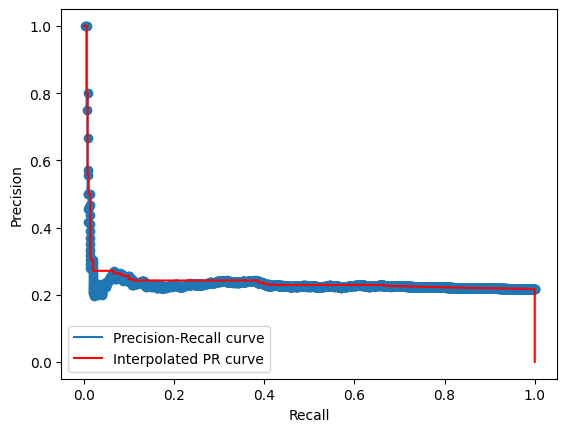

	Query 2


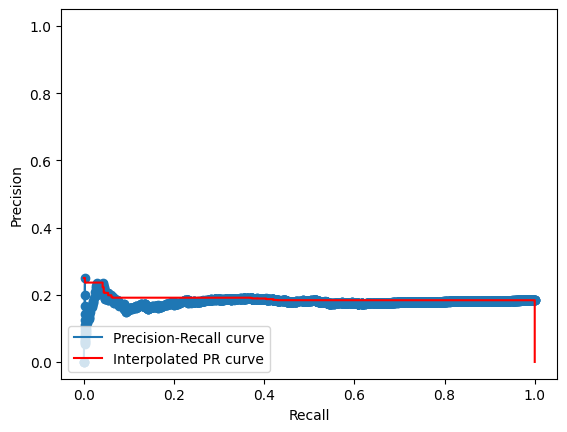

	Query 3


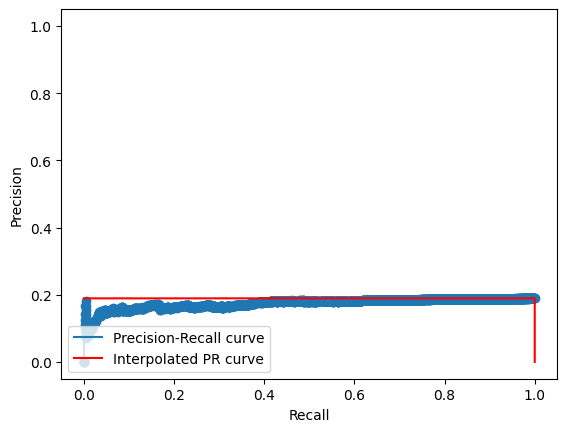

	Query 4


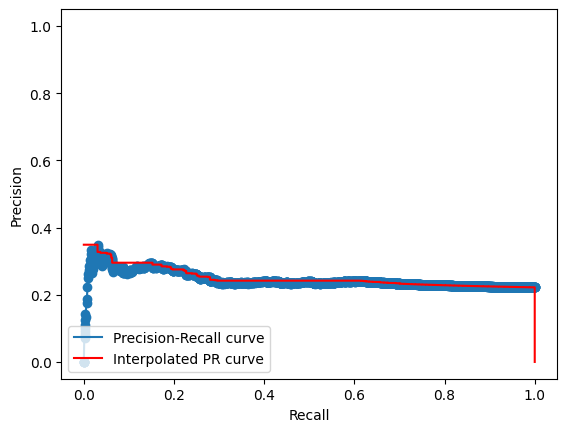

	Query 5


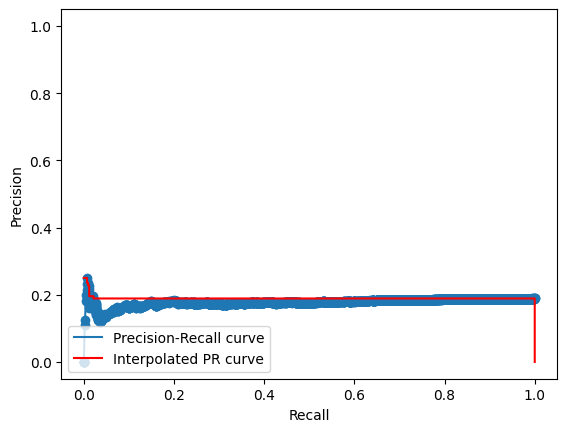

In [ ]:
from evaltools import evaluate

method = 'prec_rec'
evaluate(method, Q, R)

## 3. Performance evaluation of the created IR model 
Code provided in class

In [117]:
def evaluate(ex,Q,R):
    nq=len(Q)
    nd=len(Q[0])
    R_=np.array(R)
    R_=.5*(R_+1)
    Prec_tot=[]
    Rec_tot=[]    
    
    def compute_PR(print_screen=True):
        Prec_tot=[]
        Rec_tot=[]        
        if print_screen:
            print('Precision and Recall at k for k=1,...,%d' % nd)      
        for q in range(nq):
            q1 = q + 1
            r = R_[q,:]
            if print_screen:
                print('\tQuery %d' % q1)
            Prec_q=[]
            Rec_q=[]
            for k in range(nd):
                k1 = k + 1
                Prec=np.sum(r[:k1])/k1
                Rec=np.sum(r[:k1])/np.sum(r)    
                # if np.sum(r) == 0:
                #     Prec = 0
                #     Rec = 0
                # else:
                #     Prec = np.sum(r[:k1]) / k1
                #     Rec = np.sum(r[:k1]) / np.sum(r)
                if print_screen:                    
                    print('\t\tP(%d)=%d/%d=%.2f,\tR(%d)=%d/%d=%.2f' % (k1, np.sum(r[:k1]), k1, Prec, k1, np.sum(r[:k1]), np.sum(r), Rec))
                Prec_q.append(Prec)
                Rec_q.append(Rec)
            Prec_tot.append(Prec_q)
            Rec_tot.append(Rec_q)
        Prec_tot = np.array(Prec_tot)
        Rec_tot = np.array(Rec_tot)
        return Prec_tot, Rec_tot

    def compute_TPFP(TP_rate=None):
        TP_tot=[]        
        FP_tot=[]        
        print('TP_rate and FP_rate at k for k=1,...,%d'%nd)      
        for q in range(nq):
            q1=q+1
            r=R_[q,:]
            nr=1-r
            print('\tQuery %d'%q1)
            TP_q=[]
            FP_q=[]
            for k in range(nd):
                k1=k+1
                TP=np.sum(r[:k1])/np.sum(r)                
                FP=np.sum(nr[:k1])/np.sum(nr)
                
                print('\t\tTP_rate(%d)=R(%d)=%d/%d=%.2f\t FP_rate(%d)=%d/%d=%.2f\t'\
                     %(k1, k1, np.sum(r[:k1]),np.sum(r),TP, k1,np.sum(nr[:k1]),np.sum(nr),FP))
                TP_q.append(TP)
                FP_q.append(FP)
            TP_tot.append(TP_q)
            FP_tot.append(FP_q)
        TP_tot=np.array(TP_tot)
        FP_tot=np.array(FP_tot)
        return TP_tot, FP_tot        
    if ex=='prec_rec' or ex=='all':        
        Prec_tot, Rec_tot=compute_PR()
        print('\n Draw the Precision-Recall curve for each query')  
        # print(f"Precision: {Prec_tot}, Recall: {Rec_tot}")
        for q in range(nq):
            q1=q+1
            print('\tQuery %d'%q1)            
            plt.figure()
            Rec_q=Rec_tot[q,:]
            Prec_q=Prec_tot[q,:]
            # print(f"Rec_q: {Rec_q}, rec_q: {Prec_q}")
            plt.scatter(np.array(Rec_q), np.array(Prec_q))
            plt.plot(np.array(Rec_q), np.array(Prec_q),label='Precision-Recall curve')            
            plt.xlim([-0.05,1.05]); plt.ylim([-0.05,1.05])
            plt.xlabel('Recall'); plt.ylabel('Precision')
            R_int=np.hstack([0,Rec_q,1])
            # print(f"R_int: {R_int}")
            P_int=np.zeros(R_int.size)
            # print(f"P_int: {P_int}")
            for i_r in range(R_int.size-1):
                r=R_int[i_r]
                if i_r!=0 and R_int[i_r+1]==r:
                    P_int[i_r]=np.max(Prec_q[i_r-1:])    
                else:
                    P_int[i_r]=np.max(Prec_q[i_r:])            
            plt.plot(R_int,P_int,color='r',label='Interpolated PR curve')
            plt.legend(loc='lower left')
            plt.show()
    if ex=='r-prec' or ex=='all':        
        if Prec_tot.size == 0:
            Prec_tot, Rec_tot=compute_PR()
        print('\n Determine R-precision for each query') 
        for q in range(nq):            
            Rec_q=Rec_tot[q,:]
            Prec_q=Prec_tot[q,:]
            r=int(np.sum(R_[q]))
            q1=q+1
            print('\tQuery %d'%q1)
            print('\t\tNumber of relevant documents: %d --> P(%d)=%.2f'%(r,r,Prec_q[r-1]))
    if ex=='map' or ex=='all':        
        if Prec_tot.size == 0:
            Prec_tot, Rec_tot=compute_PR()
        print('\n Calculate the Mean Average Precision')
        APs=[]
        for q in range(nq):            
            Prec_q=Prec_tot[q,:]            
            r=int(np.sum(R_[q]))
            q1=q+1
            print('\tQuery %d'%q1)
            str_formula='1/%d '%r
            rs=np.where(R_[q]==1)[0]+1
            str_formula+='{' + ' + '.join(['P(%d)'%rs_ for rs_ in rs]) + '}'
            AP=np.mean(Prec_q[np.where(R_[q]==1)])            
            print('\t\tAP=%s=%.2f'%(str_formula, AP))
            APs.append(AP)
        APstring='1/%d {'%nq
        APstring+= ' + '.join(['AP_%d'%(q+1) for q in range(nq)]) 
        APstring+='}=1/%d {'%nq
        APstring+= ' + '.join(['%.2f'%(AP) for AP in APs]) 
        APstring+='}'        
        print('\tMAP=%s=%.2f'%(APstring, np.mean(np.array(APs))))
    if ex=='roc' or ex=='all' or ex=='auc':
        TP_tot, FP_tot=compute_TPFP()    
        print('\n Draw the ROC curve for each query')  
        for q in range(nq):
            q1=q+1
            print('\tQuery %d'%q1)            
            plt.figure()
            TP_q=TP_tot[q,:]
            FP_q=FP_tot[q,:]
            plt.scatter(np.array(FP_q), np.array(TP_q))
            TP_q_=np.hstack([0,TP_q,1])
            FP_q_=np.hstack([0,FP_q,1])
            plt.plot(np.array(FP_q_), np.array(TP_q_),label='ROC curve')            
            plt.xlim([-0.05,1.05]); plt.ylim([-0.05,1.05])
            plt.xlabel('FP rate'); plt.ylabel('TP rate')
            plt.show()
            if ex=='auc' or ex=='all':
                AUC=[]
                for i_x in range(TP_q_.size-1):
                    delta_x=FP_q_[i_x+1]-FP_q_[i_x]
                    base=TP_q_[i_x+1]+TP_q_[i_x]
                    AUC.append(base*delta_x/2)
                AUC=np.array(AUC)
                AUC=AUC[AUC>0]
                string_AUC=' + '.join(['%.2f'%auc for auc in AUC])
                if string_AUC!='':
                    string_AUC+=' = '    
                print('\tAUC = %s %.2f\n\n'%(string_AUC, np.sum(AUC)))            
    if ex=='clear':
        return

In [118]:
Q = []
R = []

users = user_interests.keys()
for i in users:
    qi = sim_df.sort_values(i, ascending=False)
    ri = qi['Category'].str.contains(user_interests[i][0])
    Q.append(qi)
    R.append(ri)

Precision and Recall at k for k=1,...,1440
	Query 1
		P(1)=1/1=1.00,	R(1)=1/891=0.00
		P(2)=2/2=1.00,	R(2)=2/891=0.00
		P(3)=3/3=1.00,	R(3)=3/891=0.00
		P(4)=4/4=1.00,	R(4)=4/891=0.00
		P(5)=5/5=1.00,	R(5)=5/891=0.01
		P(6)=6/6=1.00,	R(6)=6/891=0.01
		P(7)=7/7=1.00,	R(7)=7/891=0.01
		P(8)=8/8=1.00,	R(8)=8/891=0.01
		P(9)=9/9=1.00,	R(9)=9/891=0.01
		P(10)=10/10=1.00,	R(10)=10/891=0.01
		P(11)=11/11=1.00,	R(11)=11/891=0.01
		P(12)=12/12=1.00,	R(12)=12/891=0.01
		P(13)=13/13=1.00,	R(13)=13/891=0.01
		P(14)=14/14=1.00,	R(14)=14/891=0.02
		P(15)=15/15=1.00,	R(15)=15/891=0.02
		P(16)=16/16=1.00,	R(16)=16/891=0.02
		P(17)=17/17=1.00,	R(17)=17/891=0.02
		P(18)=18/18=1.00,	R(18)=18/891=0.02
		P(19)=19/19=1.00,	R(19)=19/891=0.02
		P(20)=20/20=1.00,	R(20)=20/891=0.02
		P(21)=21/21=1.00,	R(21)=21/891=0.02
		P(22)=22/22=1.00,	R(22)=22/891=0.02
		P(23)=23/23=1.00,	R(23)=23/891=0.03
		P(24)=24/24=1.00,	R(24)=24/891=0.03
		P(25)=25/25=1.00,	R(25)=25/891=0.03
		P(26)=26/26=1.00,	R(26)=26/891=0.03
		P(2

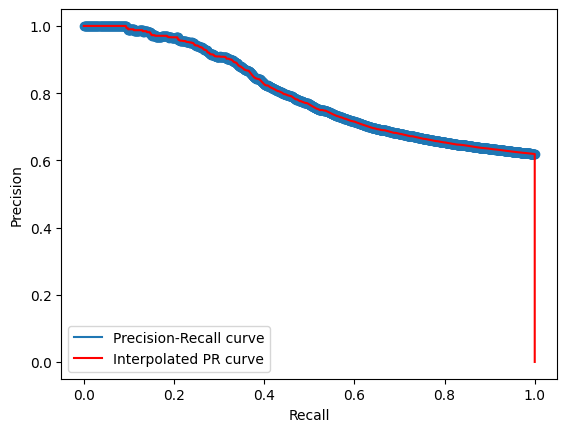

	Query 2


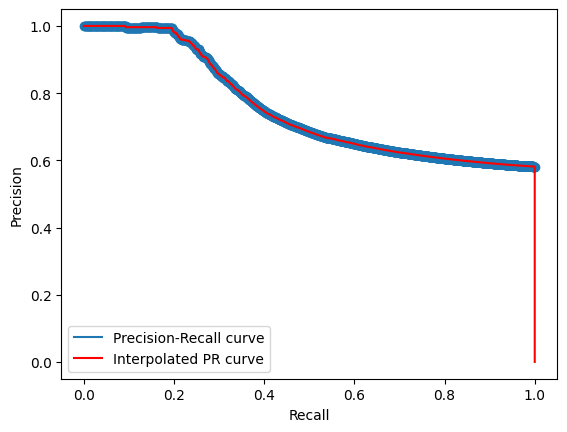

	Query 3


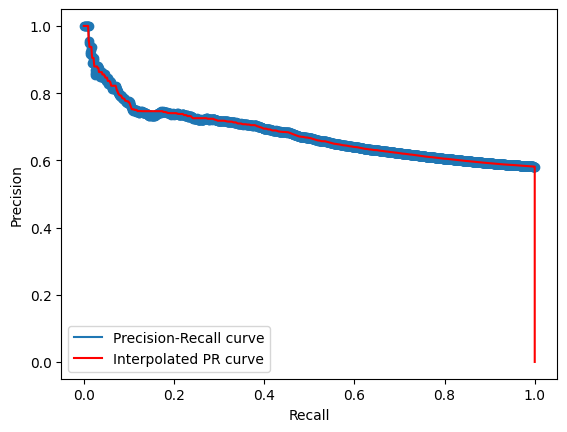

	Query 4


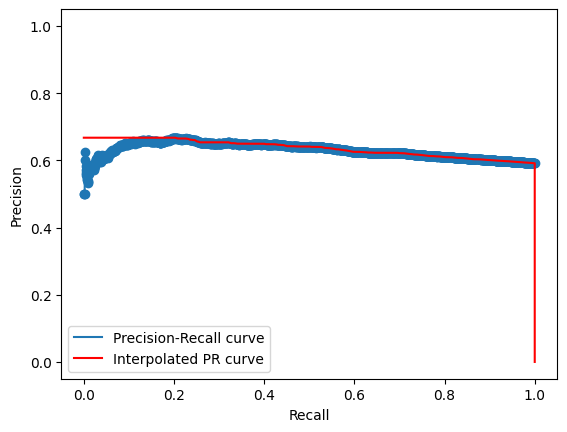

	Query 5


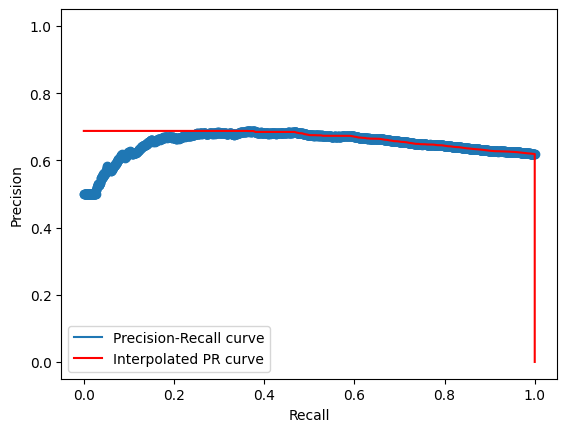

	Query 6


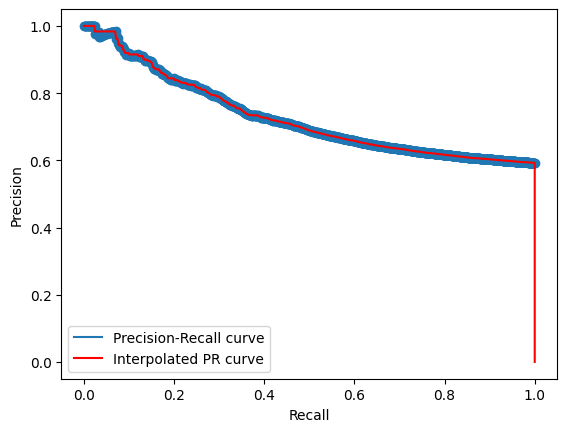

	Query 7


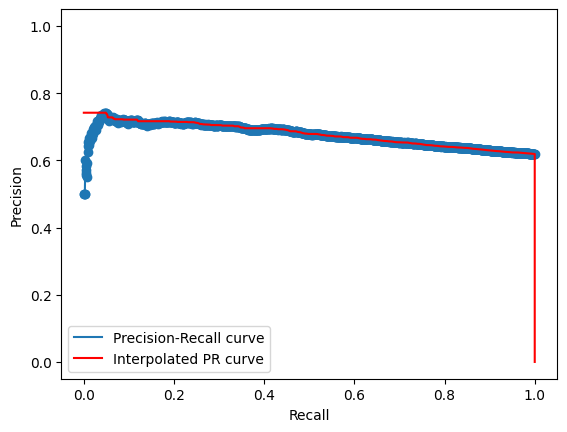


 Determine R-precision for each query
	Query 1
		Number of relevant documents: 891 --> P(891)=0.68
	Query 2
		Number of relevant documents: 837 --> P(837)=0.64
	Query 3
		Number of relevant documents: 837 --> P(837)=0.63
	Query 4
		Number of relevant documents: 851 --> P(851)=0.62
	Query 5
		Number of relevant documents: 891 --> P(891)=0.66
	Query 6
		Number of relevant documents: 853 --> P(853)=0.65
	Query 7
		Number of relevant documents: 891 --> P(891)=0.66

 Calculate the Mean Average Precision
	Query 1
		AP=1/891 {P(1) + P(2) + P(3) + P(4) + P(5) + P(6) + P(7) + P(8) + P(9) + P(10) + P(11) + P(12) + P(13) + P(14) + P(15) + P(16) + P(17) + P(18) + P(19) + P(20) + P(21) + P(22) + P(23) + P(24) + P(25) + P(26) + P(27) + P(28) + P(29) + P(30) + P(31) + P(32) + P(33) + P(34) + P(35) + P(36) + P(37) + P(38) + P(39) + P(40) + P(41) + P(42) + P(43) + P(44) + P(45) + P(46) + P(47) + P(48) + P(49) + P(50) + P(51) + P(52) + P(53) + P(54) + P(55) + P(56) + P(57) + P(58) + P(59) + P(60) + P(6

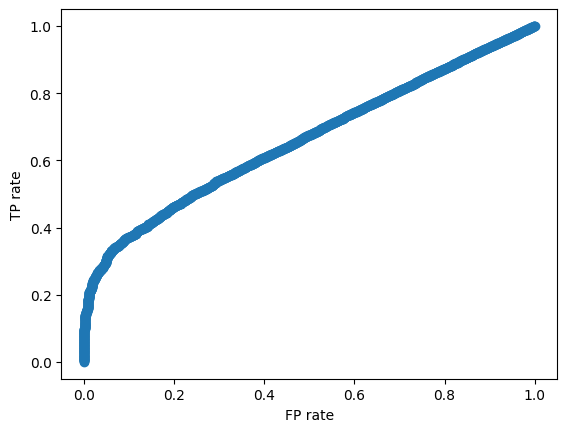

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

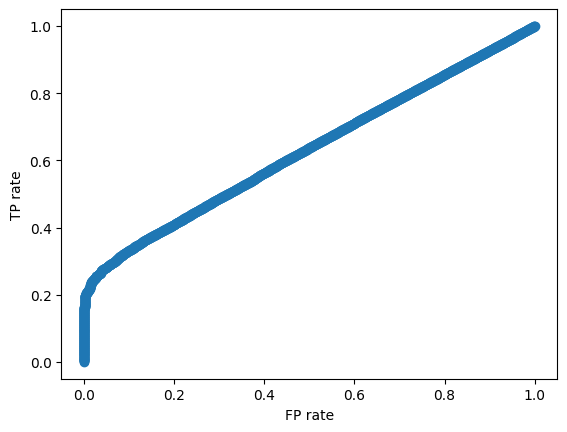

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

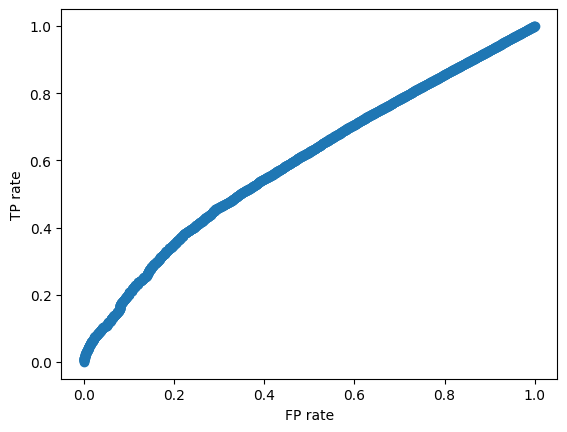

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

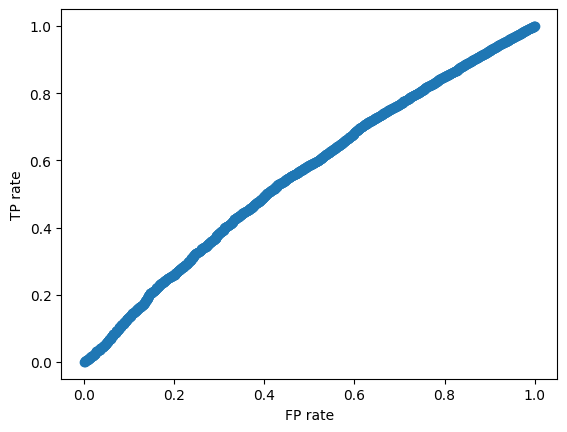

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

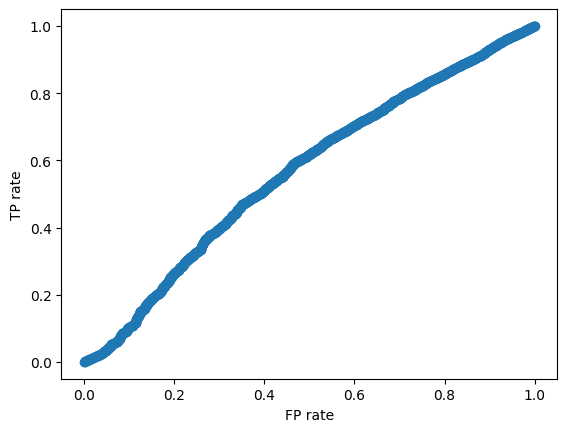

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

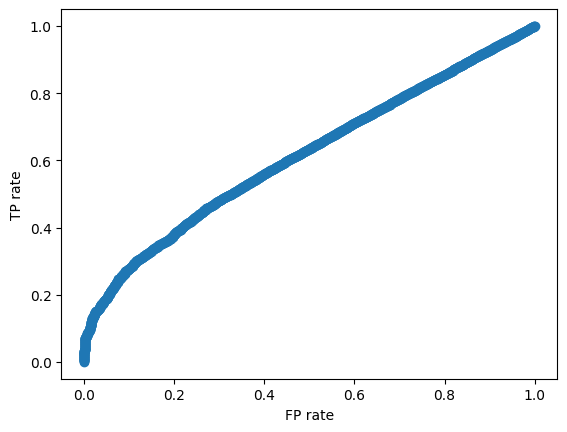

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

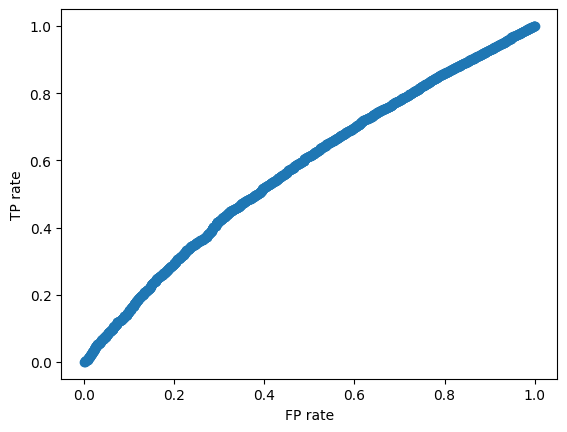

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

In [119]:
evaluate('all',Q,R)

###### Solution 2. Information retrieval system given a vector of user interests
Given a random document, the cosine similarity between the calculated vector of the document and the user's interests vector. Therefore, the most interested user is obtained.


In [120]:
random_index = random.randint(0, len(train["clean_text"]) - 1)  # Random document from the dataset.
incoming_doc_vector = document_vectors[random_index]

list_sim = []
perfiles = []
topics = []

for j in range(len(all_interests)):
    similarities = cosine_similarity(incoming_doc_vector, users_vectors[j])  # Cosine distance between the document and the users
    perfiles.append(f"user{j+1}")
    topics.append(all_interests[j])
    list_sim.append(similarities[0][0])

# Return the document, the users are going to receive that document and the main topic related to the document.

ranking = pd.DataFrame()
ranking["Users"] = perfiles
ranking['Topics'] = topics
ranking["Score"] = list_sim
ranking = ranking.sort_values('Score', ascending=False)

max_index = ranking['Score'].idxmax()  # DataFrame index of the maximum score value in the ranking
max_row = ranking.loc[max_index]  # Row with the maximum score

print("A document about:", train['Category'][random_index], ":", train["clean_text"][random_index])
# print(train['Category'][random_index], '-- ', max_row['Topics'])
print('USERS RANKING')
print(ranking)

# Print users with a score above a certain threshold
threshold = 0.015
interested_users = ranking[ranking['Score'] > threshold]
for index, row in interested_users.iterrows():
    print('User interested:', row[0])


A document about: entertainment : pixy take reading leeds pixy fighter iron maiden headline summer leeds reading festival trio rock heavyweight bill threeday event bramham park near wetherby richfield avenue reading pixy iron maiden festival gig fighter also park killer razorlight queen stone also playing twin festival held 2628 august act year lineup include charlatan marilyn manson king leon pete doherty band babyshamblers appear nmeradio stage along kasabian black rebel motorcycle club bloc party organiser mean fiddler said act still confirmed summer event excited going back reading intend fantastic time said iron maiden bruce dickinson sure fan first time veteran british metal band played reading year leeds iron maiden headline first festival friday pixy follow saturday fighter close event sunday pixy headline first reading fighter play sunday iron maiden close event weekend ticket sale priced £125
USERS RANKING
   Users         Topics     Score
3  user4       business  0.347354
2 

C:\Users\mikel\AppData\Local\Temp\ipykernel_12276\1265857954.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('User interested:', row[0])


#### 2.2. Method 2. Cosine Similarity weighted TF-IDF Vectors

## 5. Performance evaluation of the created IR model against other methods implemented by other groups.


##### 2.1.2. Manual approach
For the information retrieval, the interests of each users need to be vectorized. In order to do that, interests were defined manually. Adding interests manually allows us to have a more generalized model.  

##### Defining unique interests vectors as a TF-IDF vector 

In [121]:
# Business
final_business =  ["company", "market", "entrepreneurship","bank", "conuntry", "analyst", "economic", "startups", "financial", "marketing", "leadership", 
          "innovation", "investment", "sales", "business", "product development", "capital", "branding", "consumer", "supply chain management", 
          "market research", "entrepreneurial mindset", "competitive advantage","risk management", "growth", "startup culture", "dollar",
          "crowdfunding", "digital marketing", "social media", "customer experience", "entrepreneurial ecosystem", "networking", "e-commerce", 
          "online marketing", "data analytics", "management consulting", "strategic planning", "business ethics","group", "sustainability", 
          "corporate responsibility","globalization", "international","business", "trade", "emerging markets", "industry analysis", "economy", 
          "financial", "invest", "career", "development"]

# Tech
final_tech =  ["technology", "mobile", "technology","internet","website" ,"phone", "device", "game","gadget", "machine", "learning", "data", "science", "cloud", "computer", "cybersecurity", 
         "blockchain", "information", "virtual", "virus", "augmented", "reality", "robotics", "automation", "software", "development", "web", "development", 
         "mobile", "development", "system", "microsoft", "product", "design", "management", "agile", "methodology", "network", "digital", "transformation", "innovation", "online", 
         "venture","broadband", "capital", "media", "events", "policy", "ethics", "privacy", "patents", "copyright", "surveillance", "consumer", "printing", "drones", "nanotechnology", 
         "player"]

# Politics
final_politics = ["politics", "government", "election", "voting", "democracy", "campaign", "power", "public","people","minister","party", "leader", "tory", "international", "plan", "diplomacy", 
         "foreign policy", "war", "peace", "human", "right", "labour", "immigration", "trade", "economics", "change","taxes", "budgets", "council", "inequality", "vote", "activism", 
         "protest", "lobbying", "media", "propaganda", "chancellor", "prime", "political ideologies", "political parties", "political systems", "authoritarianism", "general", "liberalism", 
         "conservatism", "fascism", "communism", "conservative","anarchism", "right","federalism", "parliamentary system", "presidential system", "judicial system", "constitution", "sercretry", "country"]

# Sports
final_sport = ["basketball", "game", "match","football", "baseball", "hockey", "soccer", "rugby","swimming", "tennis", "golf", "athlete", "player", "training", "fitness", "nutrition", 
         "sports psychology", "performance", "strength", "endurance", "final","health", "wellness", "coach", "team", "competition", "season","time","champion", "victory", "athleticism", 
         "motivation", "dedication", "passion", "sportsmanship", "fan", "stadium", "tickets", "play", "fantasy sports", "sports media", "sports journalism", "injury", "sports science", 
         "goal", "sports technology","sports equipment", "sports apparel", "open", "sports leagues", "sports events", "sports personalities", "sports icons", "sports culture"]

# Entertainment
final_entertainment = ["entertainment", "film","movie", "television", "music","award","show", "books","oscar", "art", "performing", "arts", "theater", "comedy", "celebrities", "pop", "culture", "fashion", 
         "gaming", "streaming", "social", "media","record","producer", "band","song","single", "director", "Instagram", "influencers", "fan", "culture", "fandom", "play","role",
         "nomination","prize", "convention", "festival", "satar", "actor", "red", "carpet", "critics", "reviews", "box", "office", "ratings", "soundtracks", "visual", "effects", 
         "animation", "cartoons", "manga", "anime", "album", "horror", "fantasy","romance", "actress", "singer"]


##### Defining users
Once we have every interest as a vector with the the most common words for every category in the initial dataset, we are going to define 7 different users with different interests. The users and their interests are the following:
- User 1: sport
- User 2: tech
- User 3: tech and business
- User 4: entertainment and business
- User 5: sport and politics
´´-ñ.
- User 6: politics and entertainment
- User 7: sport and tech

Then, the words of interest for each user will be obtained and then users will be vectorized.

In [122]:
user_interests = {
    "user1": ["sport"],
    "user2": ["tech"],
    "user3": ["tech", "business"],
    "user4": ["entertainment", "business"],
    "user5": ["sport", "politics"],
    "user6": ["politics", "entertainment"],
    "user7": ["sport", "tech"]
}

# Definir una lista de todos los posibles temas de interés
all_interests = list(set([interest for interests in user_interests.values() for interest in interests]))

#users_keywords = [final_business_keywords, final_tech_keywords, final_politics_keywords, final_sports_keywords, final_entertainment_keywords]

# Obtener los vectores de palabras clave finales para cada interés
users_keywords = {}
for user, interests in user_interests.items():
    final_keywords = []
    for interest in interests:
        if interest == 'business':
            final_keywords.extend(final_business)
        elif interest == 'tech':
            final_keywords.extend(final_tech)
        elif interest == 'politics':
            final_keywords.extend(final_politics)
        elif interest == 'sport':
            final_keywords.extend(final_sport)
        elif interest == 'entertainment':
            final_keywords.extend(final_entertainment)
    users_keywords[user] = final_keywords

users_vectors = []

# User vectors for each user
for keywords in users_keywords.values():
    users_vectors.append(tfidf.transform([" ".join(keywords)]))

# Adding additional vectors for users with multiple interests
for user, interests in user_interests.items():
    if len(interests) > 1:
        combined_vector = sum(users_vectors[all_interests.index(interest)] for interest in interests) / len(interests)
        users_vectors.append(combined_vector)

print(users_vectors)



[<1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 44 stored elements in Compressed Sparse Row format>, <1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 45 stored elements in Compressed Sparse Row format>, <1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 89 stored elements in Compressed Sparse Row format>, <1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 96 stored elements in Compressed Sparse Row format>, <1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 88 stored elements in Compressed Sparse Row format>, <1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 89 stored elements in Compressed Sparse Row format>, <1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 85 stored elements in Compressed Sparse Row format>, <1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 132 stored elements in Compressed Sparse Row format>, <1x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 178 sto

###### Solution 1. Information retrieval system given a vector of user interests
Given the vector of a user define by its interests, the cosine similarity has been calculated with every document. Therefore, the most relevant documents for every user are display, taking into account the user interest. The more similarity, the more relevant the document is to the user's interest.

In [123]:
# Creating a Dataframe
sim_df = pd.DataFrame(columns=['Text', 'Category'] + list(user_interests.keys()))

sim_df['Text'] = train['clean_text']
sim_df['Category'] = train['Category']

# Calculating similarities
for user, user_vector in zip(user_interests.keys(), users_vectors):
    similarities_list = []
    for document_vector in document_vectors:
        similarity = cosine_similarity(user_vector, document_vector)
        similarities_list.append(similarity[0][0])
    sim_df[user] = similarities_list

sim_df.head()

Text  Category     user1  \
0  worldcom exboss launch defence lawyer defendin...  business  0.000000   
1  german business confidence slide german busine...  business  0.000000   
2  poll indicates economic gloom citizen majority...  business  0.010880   
3  lifestyle governs mobile choice faster better ...      tech  0.018257   
4  enron boss 168m payout eighteen former enron d...  business  0.000000   

      user2     user3     user4     user5     user6     user7  
0  0.000000  0.029666  0.037444  0.000000  0.004722  0.000000  
1  0.014465  0.111803  0.120791  0.016112  0.021092  0.010452  
2  0.018791  0.064550  0.063368  0.101164  0.095899  0.020367  
3  0.197075  0.151191  0.048103  0.043902  0.037357  0.153795  
4  0.000000  0.058844  0.092427  0.005088  0.034969  0.000000

In [124]:
sort_1 = sim_df.sort_values('user1', ascending=False)
sort_1[:10]['Text']

577     wenger shock newcastle arsenal manager arsene ...
241     wilkinson return unlikely jonny wilkinson look...
1113    gerrard play european hope steven gerrard admi...
1239    year remember irish used subliminal moment yea...
451     mobile game come news website take look game m...
389     bridge could miss rest season chelsea leftback...
1112    johnson announces june retirement former engla...
20      hewitt overcomes wobble sydney lleyton hewitt ...
881     lion blow world winner british irish lion coac...
1159    lion blow world star british irish lion coach ...
Name: Text, dtype: object

In [125]:
topics_interest = ['sport', 'tech', 'tech and business', 'entertainment and business', 'sport and politics', 'sport and politics', 
                   'politics and entertainment', 'sport and tech'] 

users_list = ['user1', 'user2', 'user3', 'user4', 'user5', 'user6', 'user7']

q=[]
r=[]

for i in range(len(users_list)):
    qi = sim_df.sort_values(users_list[i], ascending=False)
    ri = qi['Category'].str.contains(keywords[i]) 

    q.append(qi)
    r.append(ri)

Precision and Recall at k for k=1,...,1440
	Query 1
		P(1)=0/1=0.50,	R(1)=0/720=0.00
		P(2)=1/2=0.50,	R(2)=1/720=0.00
		P(3)=1/3=0.50,	R(3)=1/720=0.00
		P(4)=2/4=0.50,	R(4)=2/720=0.00
		P(5)=2/5=0.50,	R(5)=2/720=0.00
		P(6)=3/6=0.50,	R(6)=3/720=0.00
		P(7)=3/7=0.50,	R(7)=3/720=0.00
		P(8)=4/8=0.50,	R(8)=4/720=0.01
		P(9)=4/9=0.50,	R(9)=4/720=0.01
		P(10)=5/10=0.50,	R(10)=5/720=0.01
		P(11)=5/11=0.50,	R(11)=5/720=0.01
		P(12)=6/12=0.50,	R(12)=6/720=0.01
		P(13)=6/13=0.50,	R(13)=6/720=0.01
		P(14)=7/14=0.50,	R(14)=7/720=0.01
		P(15)=7/15=0.50,	R(15)=7/720=0.01
		P(16)=8/16=0.50,	R(16)=8/720=0.01
		P(17)=8/17=0.50,	R(17)=8/720=0.01
		P(18)=9/18=0.50,	R(18)=9/720=0.01
		P(19)=9/19=0.50,	R(19)=9/720=0.01
		P(20)=10/20=0.50,	R(20)=10/720=0.01
		P(21)=10/21=0.50,	R(21)=10/720=0.01
		P(22)=11/22=0.50,	R(22)=11/720=0.02
		P(23)=11/23=0.50,	R(23)=11/720=0.02
		P(24)=12/24=0.50,	R(24)=12/720=0.02
		P(25)=12/25=0.50,	R(25)=12/720=0.02
		P(26)=13/26=0.50,	R(26)=13/720=0.02
		P(27)=13/27=0.50,	R(27)

		P(1157)=578/1157=0.50,	R(1157)=578/720=0.80
		P(1158)=579/1158=0.50,	R(1158)=579/720=0.80
		P(1159)=579/1159=0.50,	R(1159)=579/720=0.80
		P(1160)=580/1160=0.50,	R(1160)=580/720=0.81
		P(1161)=580/1161=0.50,	R(1161)=580/720=0.81
		P(1162)=581/1162=0.50,	R(1162)=581/720=0.81
		P(1163)=581/1163=0.50,	R(1163)=581/720=0.81
		P(1164)=582/1164=0.50,	R(1164)=582/720=0.81
		P(1165)=582/1165=0.50,	R(1165)=582/720=0.81
		P(1166)=583/1166=0.50,	R(1166)=583/720=0.81
		P(1167)=583/1167=0.50,	R(1167)=583/720=0.81
		P(1168)=584/1168=0.50,	R(1168)=584/720=0.81
		P(1169)=584/1169=0.50,	R(1169)=584/720=0.81
		P(1170)=585/1170=0.50,	R(1170)=585/720=0.81
		P(1171)=585/1171=0.50,	R(1171)=585/720=0.81
		P(1172)=586/1172=0.50,	R(1172)=586/720=0.81
		P(1173)=586/1173=0.50,	R(1173)=586/720=0.81
		P(1174)=587/1174=0.50,	R(1174)=587/720=0.82
		P(1175)=587/1175=0.50,	R(1175)=587/720=0.82
		P(1176)=588/1176=0.50,	R(1176)=588/720=0.82
		P(1177)=588/1177=0.50,	R(1177)=588/720=0.82
		P(1178)=589/1178=0.50,	R(1178)=5

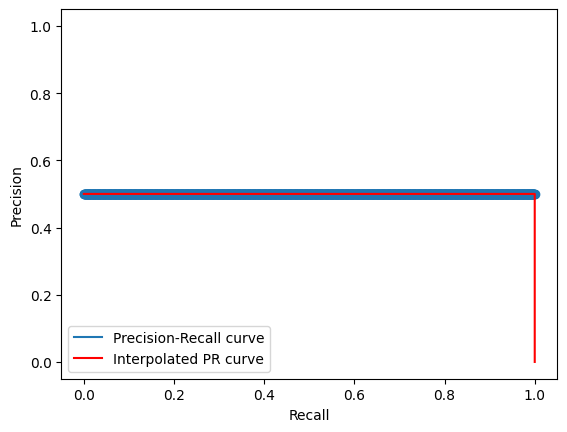

	Query 2


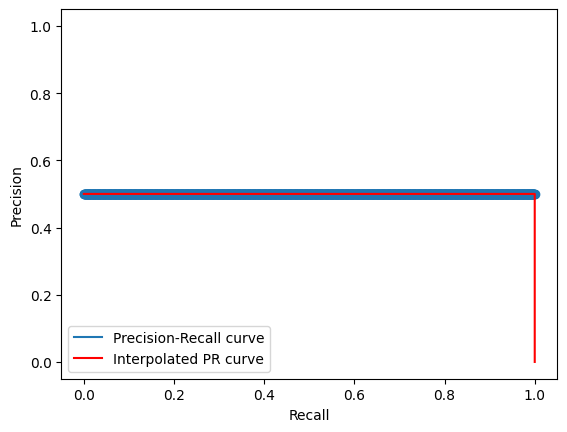

	Query 3


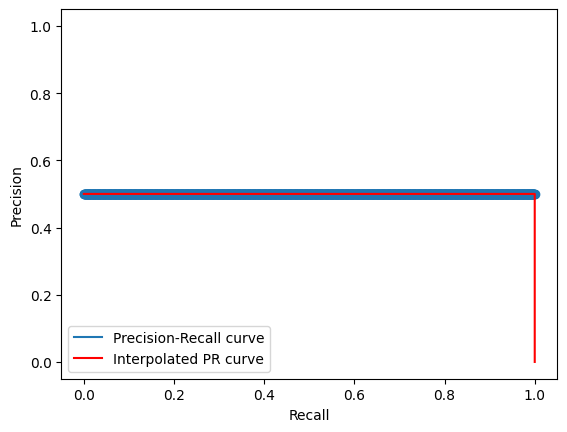

	Query 4


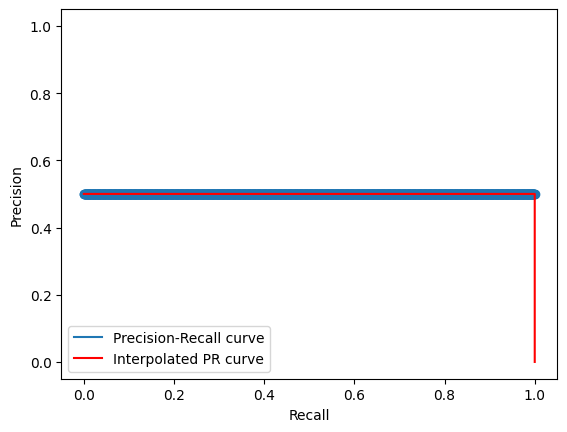

	Query 5


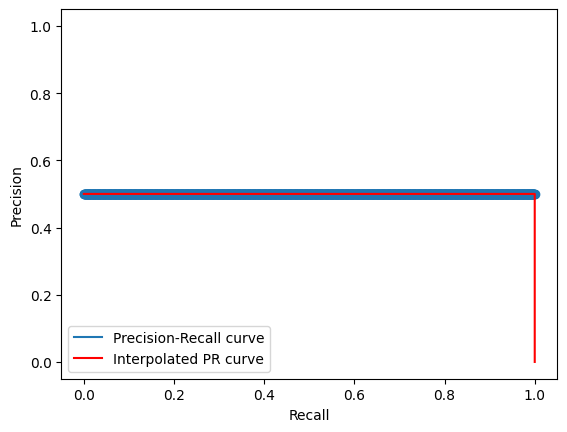

	Query 6


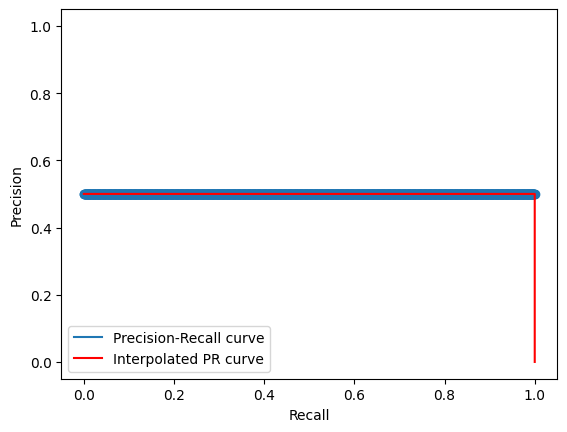

	Query 7


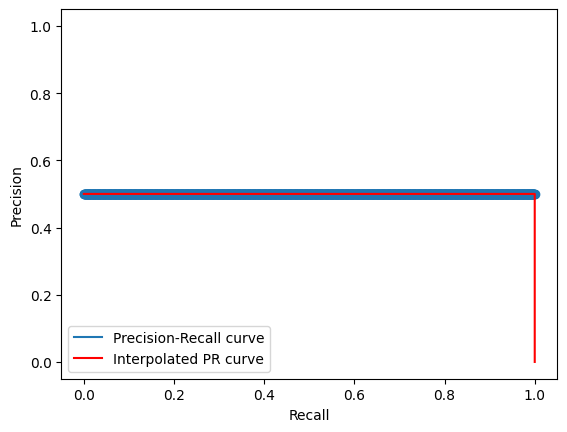


 Determine R-precision for each query
	Query 1
		Number of relevant documents: 720 --> P(720)=0.50
	Query 2
		Number of relevant documents: 720 --> P(720)=0.50
	Query 3
		Number of relevant documents: 720 --> P(720)=0.50
	Query 4
		Number of relevant documents: 720 --> P(720)=0.50
	Query 5
		Number of relevant documents: 720 --> P(720)=0.50
	Query 6
		Number of relevant documents: 720 --> P(720)=0.50
	Query 7
		Number of relevant documents: 720 --> P(720)=0.50

 Calculate the Mean Average Precision
	Query 1
		AP=1/720 {}=nan
	Query 2
		AP=1/720 {}=nan
	Query 3
		AP=1/720 {}=nan
	Query 4
		AP=1/720 {}=nan
	Query 5
		AP=1/720 {}=nan
	Query 6
		AP=1/720 {}=nan
	Query 7
		AP=1/720 {}=nan
	MAP=1/7 {AP_1 + AP_2 + AP_3 + AP_4 + AP_5 + AP_6 + AP_7}=1/7 {nan + nan + nan + nan + nan + nan + nan}=nan
TP_rate and FP_rate at k for k=1,...,1440
	Query 1
		TP_rate(1)=R(1)=0/720=0.00	 FP_rate(1)=0/720=0.00	
		TP_rate(2)=R(2)=1/720=0.00	 FP_rate(2)=1/720=0.00	
		TP_rate(3)=R(3)=1/720=0.00	 FP_rate(3)=

c:\Users\mikel\Desktop\Master\InformationRetrieval_Extraction_Integration\profile-based_retrieval\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mikel\Desktop\Master\InformationRetrieval_Extraction_Integration\profile-based_retrieval\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


		TP_rate(1177)=R(1177)=588/720=0.82	 FP_rate(1177)=588/720=0.82	
		TP_rate(1178)=R(1178)=589/720=0.82	 FP_rate(1178)=589/720=0.82	
		TP_rate(1179)=R(1179)=589/720=0.82	 FP_rate(1179)=589/720=0.82	
		TP_rate(1180)=R(1180)=590/720=0.82	 FP_rate(1180)=590/720=0.82	
		TP_rate(1181)=R(1181)=590/720=0.82	 FP_rate(1181)=590/720=0.82	
		TP_rate(1182)=R(1182)=591/720=0.82	 FP_rate(1182)=591/720=0.82	
		TP_rate(1183)=R(1183)=591/720=0.82	 FP_rate(1183)=591/720=0.82	
		TP_rate(1184)=R(1184)=592/720=0.82	 FP_rate(1184)=592/720=0.82	
		TP_rate(1185)=R(1185)=592/720=0.82	 FP_rate(1185)=592/720=0.82	
		TP_rate(1186)=R(1186)=593/720=0.82	 FP_rate(1186)=593/720=0.82	
		TP_rate(1187)=R(1187)=593/720=0.82	 FP_rate(1187)=593/720=0.82	
		TP_rate(1188)=R(1188)=594/720=0.82	 FP_rate(1188)=594/720=0.82	
		TP_rate(1189)=R(1189)=594/720=0.83	 FP_rate(1189)=594/720=0.83	
		TP_rate(1190)=R(1190)=595/720=0.83	 FP_rate(1190)=595/720=0.83	
		TP_rate(1191)=R(1191)=595/720=0.83	 FP_rate(1191)=595/720=0.83	
		TP_rate(

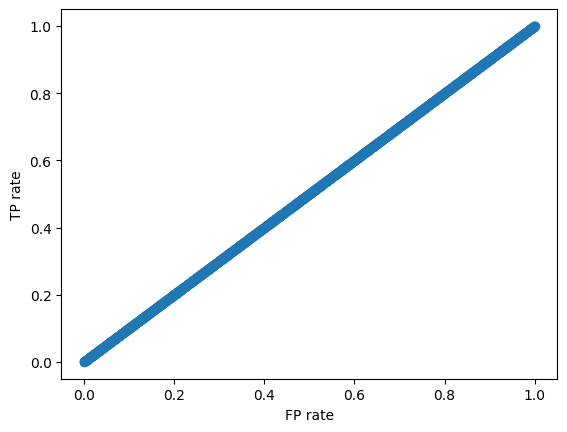

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

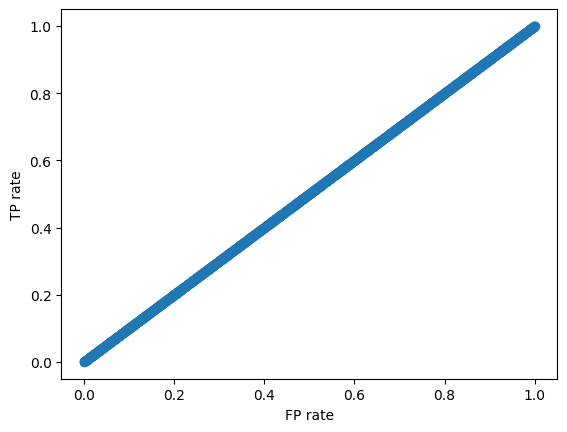

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

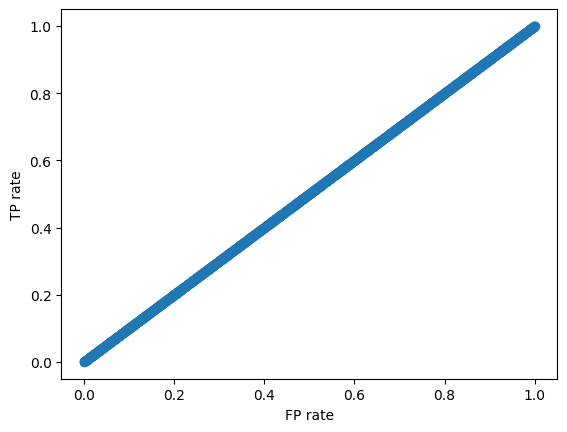

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

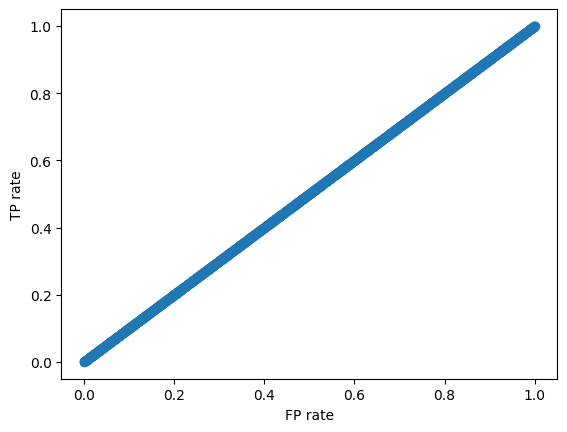

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

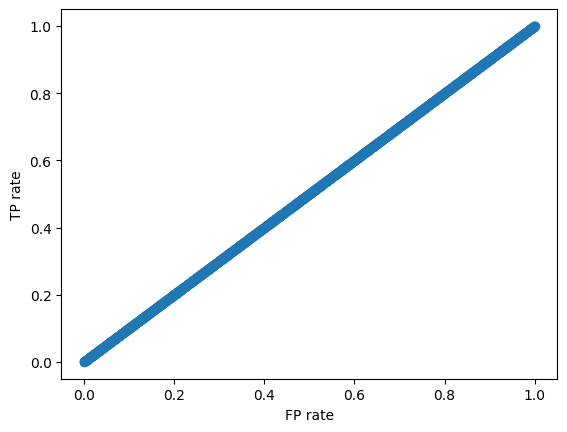

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

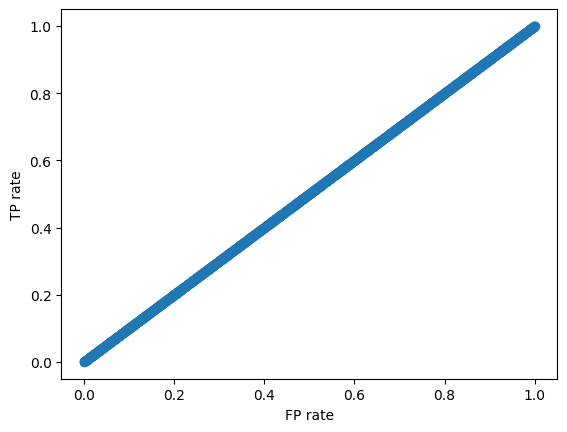

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

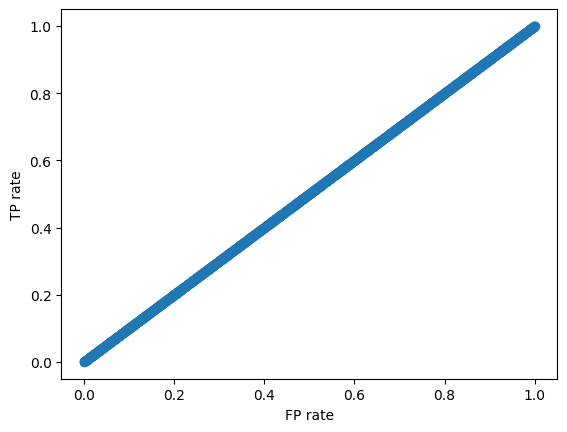

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

In [126]:
evaluate('all',q,r)